# Trees 

In [15]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.feature_selection import f_classif
import itertools
import sys
import importlib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OrdinalEncoder
# from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis 
# from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, CategoricalNB, ComplementNB, GaussianNB, MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, make_scorer
from joblib import Parallel, delayed, parallel_backend
from threadpoolctl import threadpool_limits
import matplotlib.pylab as plt
import os
from sklearn.inspection import permutation_importance
from scipy.stats import norm, t
from sklearn.base import clone 
from sklearn.tree import DecisionTreeClassifier

sys.path.append("../")
from proj_mod import training
importlib.reload(training);

## Data importing

In [2]:
df=pd.read_csv("../data/raw.csv")
features=list(df.columns)[1:]
target=["Y"]
feat=df[features]
tar=df[target]
# x_t, x_v, y_t, y_v= train_test_split(feat,tar, test_size=0.2, random_state=0, stratify=tar["Y"])
n_splits=5

## For all raw features 

In [3]:
eva_pipe=Pipeline([("DataCreater", training.data_creator()),("DataSelector",training.data_selector())])
tar_arr=np.ravel(tar.values)
eva_pipe.fit(X=feat,y=tar)
eva_out=eva_pipe.transform(X=feat)
eva_out.columns

Index(['X1', 'X3', 'X5', 'X6', 'mean', 'F_w_mean', 'above_4', 'above_5'], dtype='object')

In [4]:
eva_pipe["DataSelector"].sel_

,features,f score,p value,X1,X2,X3,X4,X5,X6,mean,F_w_mean,above_3,above_4,above_5,Y
0,X1,10.561708,0.001486,1.000000,0.059797,0.283358,0.087541,0.432772,0.411873,0.607460,0.834641,0.266199,0.492355,0.604855,0.280160
2,X3,2.886959,0.091807,0.283358,0.184129,1.000000,0.302618,0.358397,0.203750,0.676149,0.532371,0.442280,0.638649,0.481689,0.150838
4,X5,6.582716,0.011488,0.432772,0.039996,0.358397,0.293115,1.000000,0.320195,0.712786,0.806779,0.491804,0.616787,0.586695,0.224522
5,X6,3.586849,0.060568,0.411873,-0.062205,0.203750,0.215888,0.320195,1.000000,0.540096,0.574523,0.261704,0.458477,0.490605,0.167669
6,mean,7.306094,0.007836,0.607460,0.426097,0.676149,0.557803,0.712786,0.540096,1.000000,0.869373,0.687659,0.848710,0.773920,0.235885
7,F_w_mean,12.615311,0.000542,0.834641,0.078909,0.532371,0.298662,0.806779,0.574523,0.869373,1.000000,0.498831,0.743851,0.761327,0.303878
9,above_4,7.194813,0.008308,0.492355,0.268810,0.638649,0.521454,0.616787,0.458477,0.848710,0.743851,0.465645,1.000000,0.546995,0.234181
10,above_5,6.520675,0.011874,0.604855,0.215269,0.481689,0.389949,0.586695,0.490605,0.773920,0.761327,0.229256,0.546995,1.000000,0.223515


In [5]:
eva_pipe["DataSelector"].total_

,features,f score,p value,X1,X2,X3,X4,X5,X6,mean,F_w_mean,above_3,above_4,above_5,Y
0,X1,10.561708,0.001486,1.000000,0.059797,0.283358,0.087541,0.432772,0.411873,0.607460,0.834641,0.266199,0.492355,0.604855,0.280160
1,X2,0.073108,0.787313,0.059797,1.000000,0.184129,0.114838,0.039996,-0.062205,0.426097,0.078909,0.500598,0.268810,0.215269,-0.024274
2,X3,2.886959,0.091807,0.283358,0.184129,1.000000,0.302618,0.358397,0.203750,0.676149,0.532371,0.442280,0.638649,0.481689,0.150838
3,X4,0.516657,0.473623,0.087541,0.114838,0.302618,1.000000,0.293115,0.215888,0.557803,0.298662,0.383442,0.521454,0.389949,0.064415
4,X5,6.582716,0.011488,0.432772,0.039996,0.358397,0.293115,1.000000,0.320195,0.712786,0.806779,0.491804,0.616787,0.586695,0.224522
5,X6,3.586849,0.060568,0.411873,-0.062205,0.203750,0.215888,0.320195,1.000000,0.540096,0.574523,0.261704,0.458477,0.490605,0.167669
6,mean,7.306094,0.007836,0.607460,0.426097,0.676149,0.557803,0.712786,0.540096,1.000000,0.869373,0.687659,0.848710,0.773920,0.235885
7,F_w_mean,12.615311,0.000542,0.834641,0.078909,0.532371,0.298662,0.806779,0.574523,0.869373,1.000000,0.498831,0.743851,0.761327,0.303878
8,above_3,1.032794,0.311482,0.266199,0.500598,0.442280,0.383442,0.491804,0.261704,0.687659,0.498831,1.000000,0.465645,0.229256,0.090886
9,above_4,7.194813,0.008308,0.492355,0.268810,0.638649,0.521454,0.616787,0.458477,0.848710,0.743851,0.465645,1.000000,0.546995,0.234181


In [6]:
range_max_depth=range(1,6+1) # 2^6= 64, we only have 100 training data, so I would like to not have each leaf have too little data. 
range_feat_combin = training.all_combin(eva_out.columns)

n_split = 5
n_repeats = 20

RSKF = RepeatedStratifiedKFold(n_splits=n_split, random_state=420, n_repeats=n_repeats)

splits = list(RSKF.split(X=feat, y=tar))

def evaluate_combo(list_f_sel_tuple, max_depth, splits, feat, tar):
    """
    Evaluate one (feature_set, n_neighbors) across all CV folds.
    
    :param list_f_sel_tuple: A tuple indicating a combination. 
    :param max_depth: The max_depth of the decision tree. 
    :param splits: A list of the pre generated splits. 
    :param feat: The feat df. 
    :param tar: The tar df. 
    :return: A dict with all the stats we want. 
    """
    list_f_sel = list(list_f_sel_tuple) 
    fold_acc = []
    fold_f1 = []

    for train_index, test_index in splits:
        x_tr, x_te = feat.iloc[train_index], feat.iloc[test_index]
        y_tr, y_te = tar.iloc[train_index], tar.iloc[test_index]

        y_tr = np.ravel(y_tr.values)
        y_te = np.ravel(y_te.values)
        

        pipe = Pipeline([
            ("DataCreate", training.data_creator()),
            ("DataSelect", training.data_selector(force=list_f_sel)),
            ("DT", DecisionTreeClassifier(max_depth=max_depth))
        ])
            
        pipe.fit(X=x_tr, y=y_tr)
        y_p = pipe.predict(X=x_te)

        fold_acc.append(accuracy_score(y_true=y_te, y_pred=y_p))
        fold_f1.append(f1_score(y_true=y_te, y_pred=y_p))

    str_features = ",".join(list_f_sel)
    acc_mean = float(np.mean(fold_acc))
    acc_std  = float(np.std(fold_acc))
    f1_mean  = float(np.mean(fold_f1))
    f1_std   = float(np.std(fold_f1))
    above_73 = float((np.array(fold_acc) >= 0.73).sum() / (len(splits)))
    norm_above_73 = float(1-norm.cdf(0.73, loc=acc_mean, scale=acc_std))
    acc_mean_above_73 = float(1-norm.cdf(0.73, loc=acc_mean, scale=acc_std/np.sqrt(len(splits))))

    msg = (
        "_"*20 + "\n"
        + f"Currently used features {str_features} and max depth {max_depth}.\n"
        + f"This combo has f1 mean {f1_mean} and f1 std {f1_std}, \n"
        + f"with acc mean {acc_mean} acc std {acc_std}, "
        + f"and sureness of beating 73% {above_73}.\n"
        + "_"*20
    )

    return {
        #Hyper-parameters
        "features": str_features,
        "max_depth": max_depth,
        #Performance
        "acc_mean": acc_mean,
        "acc_std": acc_std,
        "f1_mean": f1_mean,
        "f1_std": f1_std,
        "above_73": above_73,
        "norm_above_73": norm_above_73,
        "acc_mean_above_73": acc_mean_above_73,
        #Log
        "log": msg,
    }

jobs = list(itertools.product(range_feat_combin, range_max_depth))

results = Parallel(n_jobs=-1, backend="loky", verbose=10)(
    delayed(evaluate_combo)(feat_sel, max_depth, splits, feat, tar)
    for feat_sel, max_depth in jobs
)

list_feat      = [r["features"] for r in results]
list_max_depth = [r["max_depth"] for r in results]
list_acc_mean  = [r["acc_mean"] for r in results]
list_acc_std   = [r["acc_std"] for r in results]
list_f1_mean   = [r["f1_mean"] for r in results]
list_f1_std    = [r["f1_std"] for r in results]
list_above_73  = [r["above_73"] for r in results]
list_norm_above_73 = [r["norm_above_73"] for r in results] 
list_acc_mean_above_73 = [r["acc_mean_above_73"] for r in results]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:   58.9s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:  

In [7]:
df_results = pd.DataFrame({
    #Hyper-parameters
    "features": list_feat,
    "max_depth": list_max_depth,
    #Performances
    "acc_mean": list_acc_mean,
    "acc_std": list_acc_std,
    "f1_mean": list_f1_mean,
    "f1_std": list_f1_std,
    "above_73": list_above_73,
    "norm_above_73": list_norm_above_73, 
    "acc_mean_above_73": list_acc_mean_above_73
})

In [8]:
df_results.sort_values(by=["above_73"],ascending=False)

,features,max_depth,acc_mean,acc_std,f1_mean,f1_std,above_73,norm_above_73,acc_mean_above_73
55,"X1,X5",2,0.662585,0.088865,0.651706,0.101472,0.24,0.224039,1.643130e-14
56,"X1,X5",3,0.656292,0.092366,0.673031,0.104301,0.23,0.212436,7.771561e-16
259,"X1,X5,mean",2,0.654985,0.087124,0.639545,0.107970,0.23,0.194613,0.000000e+00
299,"X1,X6,above_4",6,0.657646,0.096584,0.692288,0.100921,0.23,0.226890,3.408385e-14
277,"X1,X5,above_5",2,0.659077,0.090757,0.646544,0.108774,0.23,0.217265,2.775558e-15
...,...,...,...,...,...,...,...,...,...
46,above_5,5,0.540769,0.072830,0.562346,0.106940,0.00,0.004685,0.000000e+00
47,above_5,6,0.540769,0.072830,0.562346,0.106940,0.00,0.004685,0.000000e+00
8,X3,3,0.526646,0.068060,0.534121,0.097088,0.00,0.001405,0.000000e+00
7,X3,2,0.529708,0.070670,0.538678,0.095604,0.00,0.002297,0.000000e+00


In [9]:
df_results.sort_values(by=["f1_mean"],ascending=False)

,features,max_depth,acc_mean,acc_std,f1_mean,f1_std,above_73,norm_above_73,acc_mean_above_73
296,"X1,X6,above_4",3,0.665677,0.078387,0.736353,0.076641,0.16,0.205941,1.110223e-16
734,"X1,X6,above_4,above_5",3,0.658569,0.076263,0.731562,0.074692,0.12,0.174472,0.000000e+00
656,"X1,X5,X6,above_4",3,0.659769,0.086857,0.728922,0.082939,0.20,0.209380,3.330669e-16
1124,"X1,X5,X6,above_4,above_5",3,0.653477,0.084357,0.723537,0.083627,0.17,0.182168,0.000000e+00
65,"X1,X6",6,0.655185,0.082393,0.719560,0.082094,0.18,0.181930,0.000000e+00
...,...,...,...,...,...,...,...,...,...
468,"X5,mean,above_5",1,0.502523,0.064440,0.483786,0.188152,0.00,0.000208,0.000000e+00
90,"X3,X5",1,0.520769,0.071565,0.483442,0.151757,0.00,0.001730,0.000000e+00
408,"X3,mean,above_5",1,0.505385,0.058106,0.481073,0.176552,0.00,0.000055,0.000000e+00
798,"X3,X5,mean,above_5",1,0.496985,0.060698,0.476568,0.179682,0.00,0.000062,0.000000e+00


In [10]:
df_results.sort_values(by=["acc_mean_above_73"],ascending=False)

,features,max_depth,acc_mean,acc_std,f1_mean,f1_std,above_73,norm_above_73,acc_mean_above_73
599,"X1,X3,X6,above_4",6,0.661200,0.100885,0.683781,0.112188,0.22,0.247632,4.564238e-12
299,"X1,X6,above_4",6,0.657646,0.096584,0.692288,0.100921,0.23,0.226890,3.408385e-14
55,"X1,X5",2,0.662585,0.088865,0.651706,0.101472,0.24,0.224039,1.643130e-14
277,"X1,X5,above_5",2,0.659077,0.090757,0.646544,0.108774,0.23,0.217265,2.775558e-15
298,"X1,X6,above_4",5,0.655846,0.093912,0.693330,0.101857,0.20,0.214879,1.443290e-15
...,...,...,...,...,...,...,...,...,...
508,"X6,mean,above_5",5,0.514554,0.089021,0.568607,0.116911,0.01,0.007756,0.000000e+00
507,"X6,mean,above_5",4,0.514862,0.081482,0.589743,0.110465,0.00,0.004141,0.000000e+00
506,"X6,mean,above_5",3,0.518908,0.081538,0.605642,0.115544,0.00,0.004814,0.000000e+00
505,"X6,mean,above_5",2,0.536692,0.067721,0.635513,0.111950,0.00,0.002155,0.000000e+00


In [11]:
df_results.sort_values(by=["acc_mean"],ascending=False)

,features,max_depth,acc_mean,acc_std,f1_mean,f1_std,above_73,norm_above_73,acc_mean_above_73
296,"X1,X6,above_4",3,0.665677,0.078387,0.736353,0.076641,0.16,0.205941,1.110223e-16
55,"X1,X5",2,0.662585,0.088865,0.651706,0.101472,0.24,0.224039,1.643130e-14
599,"X1,X3,X6,above_4",6,0.661200,0.100885,0.683781,0.112188,0.22,0.247632,4.564238e-12
656,"X1,X5,X6,above_4",3,0.659769,0.086857,0.728922,0.082939,0.20,0.209380,3.330669e-16
657,"X1,X5,X6,above_4",4,0.659215,0.087289,0.710651,0.085692,0.20,0.208705,2.220446e-16
...,...,...,...,...,...,...,...,...,...
136,"X5,mean",5,0.498277,0.077998,0.518480,0.133332,0.00,0.001485,0.000000e+00
353,"X3,X5,mean",6,0.497323,0.084501,0.541004,0.120607,0.00,0.002948,0.000000e+00
798,"X3,X5,mean,above_5",1,0.496985,0.060698,0.476568,0.179682,0.00,0.000062,0.000000e+00
352,"X3,X5,mean",5,0.495215,0.083957,0.516506,0.133023,0.00,0.002583,0.000000e+00


In [13]:
df_results.to_csv("../data/DT_results_exhaust_raw6.csv", index=False)

I prefer 599 the most. 

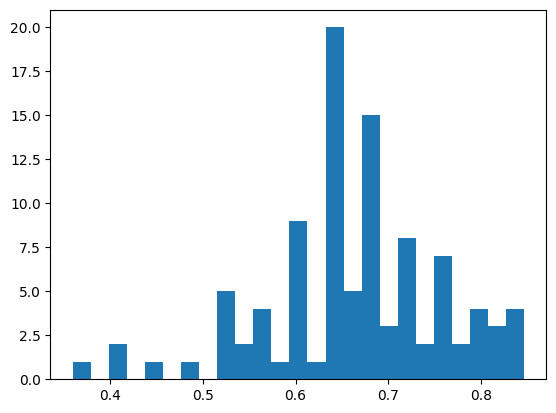

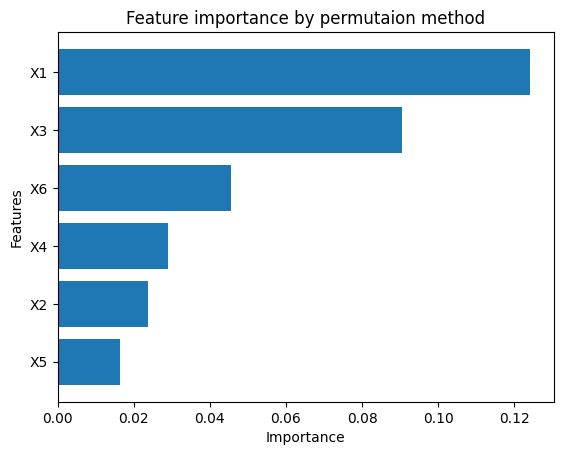

[[0.28233846 0.16996923]
 [0.16998462 0.37770769]]


In [16]:
n_split = 5
n_repeats = 20
RSKF = RepeatedStratifiedKFold(n_splits=n_split, random_state=420, n_repeats=n_repeats)
splits = list(RSKF.split(X=feat, y=tar))
pipe = Pipeline([
            ("DataCreate", training.data_creator()),
            ("DataSelect", training.data_selector(force=["X1","X3","X6","above_4"])),
            ("DT", DecisionTreeClassifier(max_depth=6))
        ])
training.show_result(splits=splits,pipe=pipe,feat=feat,tar=tar)

Interesting, might investigate further later. 